In [391]:
import random 
from typing import Optional
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [392]:
class Agent:

    def __init__(self):
        self.position = 0                                             #posición inicial, todos los autos entran al inicio de la autopista
        self.max_velocity = 80/3.6                                    #velocidad maxima, todos los autos tienen la misma velocidad maxima (sabemos que en la Gral. Paz es de 80 km/h)  
        self.length = 5                                               #longitud del vehiculo, todos los autos tienen la misma longitud 
        self.front_agent = None                                       #agente de adelante
        self.back_agent = None                                        #agente de atras
        
        '''
        velocidad de agente es generada a partir de la distribución triangular con los siguientes parametros:
        - 30,000 m/s: velocidad minima
        - 100,000 m/s: velocidad maxima
        - 70,000 m/s: moda
        '''
        self.velocity = random.triangular(30/3.6, 100/3.6, 70/3.6)
        self.time = 0
        self.arrival_time = 0
    
        self.reaction_time = random.normalvariate(1, 0.2) 
    
    def __str__(self):
        front_agent_info = (
            f"(t={self.front_agent.time}, x={self.front_agent.position}, "
            f"v={self.front_agent.velocity})"
            if self.front_agent is not None else "None"
        )
        
        back_agent_info = (
            f"(t={self.back_agent.time}, x={self.back_agent.position}, "
            f"v={self.back_agent.velocity})"
            if self.back_agent is not None else "None"
        )
        
        return (
            f"Agent(t={self.time}, at={self.arrival_time}, x={self.position}, "
            f"v={self.velocity}, rt={self.reaction_time}, "
            f"fa={front_agent_info}, ba={back_agent_info})"
        )

    def dist_to_front_agent(self):
        if self.front_agent == None:
            return None

        else: #hay otro agente adelante
            return abs(self.position - self.front_agent.position - self.length)


    def dist_to_back_agent(self):
        if self.back_agent == None:
            return None

        else: #hay otro agent atras
            return abs(self.back_agent.position - self.position - self.back_agent.length)

    def speed_variation(self):
        if self.dist_to_front_agent() == None or self.dist_to_front_agent() >= 20:
            self.velocity = random.normalvariate(self.velocity, 5/3.6)


    def reduce_speed(self):
        # si se encuentra "cerca" del agente de adelante, reducirá su velocidad mediante una distribución exponencial con media 1.
        if self.dist_to_front_agent() is not None and self.dist_to_front_agent() < 10:
            reduction = (self.velocity - self.front_agent.velocity) / (1 - random.expovariate(1))
            self.velocity -= reduction  # Reducir la velocidad
            
        # si se encuentra "lejos" del agente de adelante, reducirá su velocidad mediante una distribución exponencial con media 3.
        elif self.dist_to_front_agent() is not None and 10 <= self.dist_to_front_agent() <= 20:
            reduction = (self.velocity - self.front_agent.velocity) /(1 - random.expovariate(3))
            self.velocity -= reduction  # Reducir la velocidad


    def move(self):
        self.position = self.position + self.velocity * 1 
    
    def get_position(self):
        return self.position

    def update(self):
        self.move()
        self.reduce_speed()
        self.speed_variation()

In [397]:
class Road:
    
    def __init__(self, m:int, c:bool):
        self.km = m
        self.agents = []
        self.time = 0
        self.total_time = 700
        self.congestion = c
    
    def add_agent(self, rate):
        # Si no hay agentes en la Gral.Paz, agregamos el primer agente
        if not self.agents:
            print("Agregando primer agente...")
            self.agents.append(Agent())
            print("Primer agente agregado: " + str(self.agents[0]))
            
            self.time_to_next_arrival = stats.expon.rvs(scale=1/rate)
            self.first_agent_added = True
        else:
            # Verificamos el tiempo desde el último agente
            if self.time - self.agents[-1].arrival_time > self.time_to_next_arrival:
                # print("Agregando agente nro. ", len(self.agents))
                # Agregamos un nuevo agente a la lista
                new_agent = Agent()
                self.agents.append(new_agent)
                new_agent.arrival_time = self.time
                self.time_to_next_arrival = stats.expon.rvs(scale=1/rate)
                
                if len(self.agents) == 2:
                    new_agent.front_agent = self.agents[-2]
                    self.agents[-2].back_agent = new_agent

                    # Configuramos el front y back car para el nuevo agente
                elif len(self.agents) >= 2:
                    new_agent.back_agent = self.agents[-2]
                    self.agents[-2].front_agent = new_agent

        self.update_road()

    def time_lapse(self):
        while self.time < self.total_time:
            if self.congestion == True:
                # Agrega autos con distribución exponencial negativa con media = 15
                self.add_agent(15)
            else:
                # Agrega autos con distribución exponencial negativa con media = 45
                self.add_agent(45)
        
    
    def update_road(self):
        for agent in self.agents:
            agent.update()
            print("Estado agente nro:", self.agents.index(agent), "->", agent)
            # print("Posición del agente:", self.agents.index(agent), "->", agent.get_position())
            
            #Si el agente llega al final de la carretera lo eliminamos
            if agent.get_position() > self.km:
                self.agents.remove(agent)

            #Reasignamos el front y back car de los agentes extremos de la lista
            if len(self.agents) > 0:
                self.agents[0].front_agent = None

        self.time += 1
        self.time_lapse()
        
    def plot(self):
        positions = []  # Lista para almacenar las posiciones de los agentes
        for agent in self.agents:
            positions.append(agent.get_position())  # Almacena la posición del agente en la lista

        return positions  # Devuelve la lista de posiciones para la animación

In [ ]:
road = Road(m=25000, c=True)
road.time_lapse()

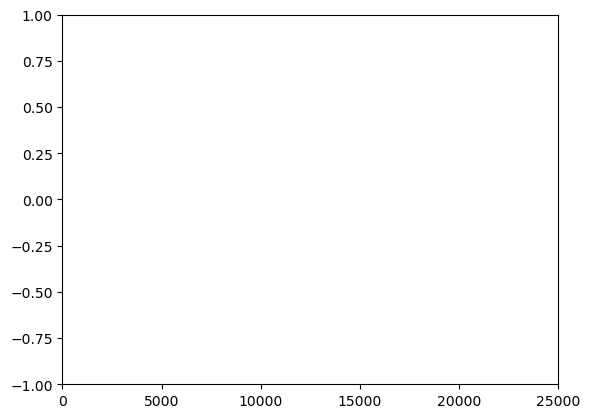

In [395]:
# Configura la figura y el eje para la animación
fig, ax = plt.subplots()
ax.set_xlim(0, road.km)
ax.set_ylim(-1, 1)  # Ajusta esto según tus necesidades

# Crea una línea para representar los agentes
line, = ax.plot([], [], 'o', markersize=5)

def init():
    line.set_data([], [])
    return line,

def animate(frame):
    # Actualiza la posición de los agentes en la animación
    positions = [agent.get_position() for agent in road.agents]
    print(positions)
    line.set_data(positions, 0)  # La posición en y es 5 (altura arbitraria)
    return line,

# Crea la animación
ani = FuncAnimation(fig, animate, frames=road.total_time, init_func=init, blit=True)

plt.show()
